Trial 1/10
  Round 1/10000
  Round 1001/10000
  Round 2001/10000
  Round 3001/10000
  Round 4001/10000
  Round 5001/10000
  Round 6001/10000
  Round 7001/10000
  Round 8001/10000
  Round 9001/10000
Trial 2/10
  Round 1/10000
  Round 1001/10000
  Round 2001/10000
  Round 3001/10000
  Round 4001/10000
  Round 5001/10000
  Round 6001/10000
  Round 7001/10000
  Round 8001/10000
  Round 9001/10000
Trial 3/10
  Round 1/10000
  Round 1001/10000
  Round 2001/10000
  Round 3001/10000
  Round 4001/10000
  Round 5001/10000
  Round 6001/10000
  Round 7001/10000
  Round 8001/10000
  Round 9001/10000
Trial 4/10
  Round 1/10000
  Round 1001/10000
  Round 2001/10000
  Round 3001/10000
  Round 4001/10000
  Round 5001/10000
  Round 6001/10000
  Round 7001/10000
  Round 8001/10000
  Round 9001/10000
Trial 5/10
  Round 1/10000
  Round 1001/10000
  Round 2001/10000
  Round 3001/10000
  Round 4001/10000
  Round 5001/10000
  Round 6001/10000
  Round 7001/10000
  Round 8001/10000
  Round 9001/10000
Trial 6/10

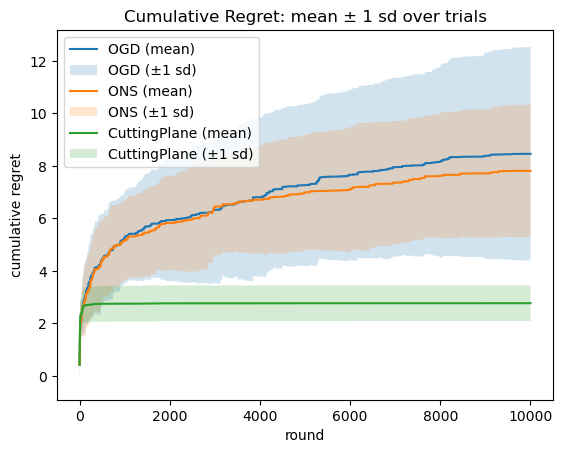

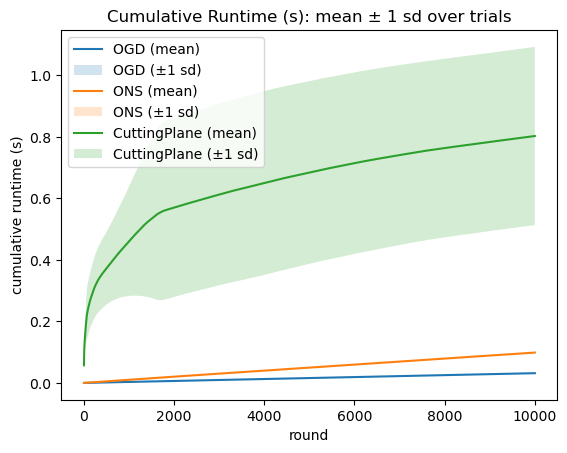

[OGD]  Regret (T): mean=8.461, sd=4.071 | Runtime (T): mean=0.032s, sd=0.000s
[ONS]  Regret (T): mean=7.810, sd=2.523 | Runtime (T): mean=0.099s, sd=0.001s
[CuttingPlane]  Regret (T): mean=2.769, sd=0.678 | Runtime (T): mean=0.803s, sd=0.290s


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import time

# =========================================================
# Configuration
# =========================================================
n = 2            # Dimension
T = 10000         # Number of rounds
radius = 1.0      # Radius of the unit ball (Theta)
n_trials = 10     # Number of independent trials
cp_init_factor = 10000  # CuttingPlane: #samples at t=1 is n * cp_init_factor
print_every = 1000      # Print progress per this many rounds (per trial)

# =========================================================
# Sampling utilities
# =========================================================
def sample_unit_sphere(n, rng):
    """Sample a point uniformly from the unit sphere in R^n"""
    x = rng.standard_normal(n)
    return x / norm(x)

def sample_unit_ball(n, rng):
    """Sample a point uniformly from the unit L2 ball in R^n"""
    x = sample_unit_sphere(n, rng)
    r = rng.random() ** (1 / n)
    return r * x

# =========================================================
# Environment utilities
# =========================================================
def generate_line_segment(n, rng):
    """Generate a line segment X_t = {x1, x2} on the sphere (antipodal)"""
    x1 = sample_unit_sphere(n, rng)
    x2 = -x1
    return x1, x2

def argmax_on_segment(c, x1, x2):
    """Return argmax of <c, x> over a line segment {x1, x2}"""
    return x1 if np.dot(c, x1) > np.dot(c, x2) else x2

# =========================================================
# Projection utilities
# =========================================================
def project_onto_ball(v, radius=1.0):
    """Projection onto L2-ball of given radius"""
    nrm = norm(v)
    return v if nrm <= radius else radius * v / nrm

def find_lambda_and_project(A, b, radius=1.0, tol=1e-6, max_iter=100):
    """
    Generalized projection into Euclidean unit ball under A-norm.
    We search λ ≥ 0 such that ||(A + λI)^{-1} b||_2 = radius (if needed).
    """
    def w_lambda(lmbd):
        return np.linalg.solve(A + lmbd * np.eye(A.shape[0]), b)

    w0 = w_lambda(0.0)
    if norm(w0) <= radius:
        return w0

    # Binary search on λ
    lmin, lmax = 0.0, 1.0
    while norm(w_lambda(lmax)) > radius:
        lmax *= 2.0

    for _ in range(max_iter):
        lmid = 0.5 * (lmin + lmax)
        w = w_lambda(lmid)
        nrm = norm(w)
        if abs(nrm - radius) < tol:
            return w
        if nrm > radius:
            lmin = lmid
        else:
            lmax = lmid

    return w_lambda(lmid)

# =========================================================
# Algorithm hyperparameters
# =========================================================
D = 2.0  # Diameter of prediction set
K = 2.0  # Diameter of action set

eta_ogd = D * K / np.sqrt(T)  # OGD step size

H = D * K
eta_ons = 1.0 / (5.0 * H)
alpha_ons = 2.0 / (1.0 + 2.0 * eta_ons * H) ** 2
gamma_ons = alpha_ons / 2.0
eps_ons = n / (D**2 * gamma_ons**2)

# =========================================================
# Single trial runner
# =========================================================
def run_single_trial(n, T, radius, rng, cp_init_factor=10000, print_every=None):
    """
    Run one independent trial and return per-round regret and runtime arrays
    for OGD, ONS, and CuttingPlane.
    """
    # Ground-truth objective vector
    c_star = sample_unit_sphere(n, rng)

    # States
    theta_ogd = np.zeros(n)
    theta_ons = np.zeros(n)
    A_ons = eps_ons * np.eye(n)

    # Logs
    regret_ogd, regret_ons, regret_cp = [], [], []
    runtime_ogd, runtime_ons, runtime_cp = [], [], []

    feasible_points = None  # Used by CuttingPlane

    for t in range(1, T + 1):
        if print_every is not None and (t % print_every == 1):
            print(f"  Round {t}/{T}")

        # Environment: a two-point "segment"
        x1, x2 = generate_line_segment(n, rng)
        x_t = argmax_on_segment(c_star, x1, x2)

        # ----- OGD -----
        start = time.time()
        xhat_ogd = argmax_on_segment(theta_ogd, x1, x2)
        theta_ogd -= eta_ogd * (xhat_ogd - x_t)
        theta_ogd = project_onto_ball(theta_ogd, radius)
        regret_ogd.append(np.dot(c_star, x_t - xhat_ogd))
        runtime_ogd.append(time.time() - start)

        # ----- ONS -----
        start = time.time()
        xhat_ons = argmax_on_segment(theta_ons, x1, x2)
        grad_ons = eta_ons * (xhat_ons - x_t)
        A_ons += np.outer(grad_ons, grad_ons)
        b_ons = A_ons @ theta_ons - grad_ons / gamma_ons
        theta_ons = find_lambda_and_project(A_ons, b_ons, radius=radius)
        regret_ons.append(np.dot(c_star, x_t - xhat_ons))
        runtime_ons.append(time.time() - start)

        # ----- CuttingPlane (very costly if cp_init_factor is large) -----
        start = time.time()
        if t == 1:
            # Initialize feasible set with many random points in the ball
            # Note: this can be memory/time heavy; tune cp_init_factor accordingly.
            feasible_points = [sample_unit_ball(n, rng) for _ in range(n * cp_init_factor)]
        theta_cp = np.mean(feasible_points, axis=0)

        xhat_cp = argmax_on_segment(theta_cp, x1, x2)
        normal_vec = x_t - xhat_cp

        # Add new cut constraint: (c - theta_cp)^T (x_t - xhat_cp) >= 0
        feasible_points = [c for c in feasible_points if np.dot(c - theta_cp, normal_vec) >= 0]
        if len(feasible_points) == 0:
            # If empty, re-initialize a small cloud to avoid crash (degrades the method but keeps run going)
            # You may prefer to raise an error instead depending on your experiment design.
            feasible_points = [sample_unit_ball(n, rng) for _ in range(1000)]

        theta_cp = np.mean(feasible_points, axis=0)
        regret_cp.append(np.dot(c_star, x_t - xhat_cp))
        runtime_cp.append(time.time() - start)

    return (np.array(regret_ogd), np.array(regret_ons), np.array(regret_cp),
            np.array(runtime_ogd), np.array(runtime_ons), np.array(runtime_cp))

# =========================================================
# Run multiple trials
# =========================================================
# We use an explicit SeedSequence to ensure independent and reproducible streams
master_ss = np.random.SeedSequence(27)
child_seeds = master_ss.spawn(n_trials)

reg_ogd_trials = np.zeros((n_trials, T))
reg_ons_trials = np.zeros((n_trials, T))
reg_cp_trials  = np.zeros((n_trials, T))

rt_ogd_trials = np.zeros((n_trials, T))
rt_ons_trials = np.zeros((n_trials, T))
rt_cp_trials  = np.zeros((n_trials, T))

for i in range(n_trials):
    print(f"Trial {i+1}/{n_trials}")
    rng = np.random.default_rng(child_seeds[i])

    (reg_ogd, reg_ons, reg_cp,
     rt_ogd, rt_ons, rt_cp) = run_single_trial(
        n=n, T=T, radius=radius, rng=rng,
        cp_init_factor=cp_init_factor, print_every=print_every
    )

    reg_ogd_trials[i] = np.cumsum(reg_ogd)
    reg_ons_trials[i] = np.cumsum(reg_ons)
    reg_cp_trials[i]  = np.cumsum(reg_cp)

    rt_ogd_trials[i] = np.cumsum(rt_ogd)
    rt_ons_trials[i] = np.cumsum(rt_ons)
    rt_cp_trials[i]  = np.cumsum(rt_cp)

# =========================================================
# Compute mean and std across trials
# =========================================================
def mean_std(arr2d):
    """Return (mean, std) along axis 0 (across trials)"""
    return arr2d.mean(axis=0), arr2d.std(axis=0)

m_reg_ogd, s_reg_ogd = mean_std(reg_ogd_trials)
m_reg_ons, s_reg_ons = mean_std(reg_ons_trials)
m_reg_cp,  s_reg_cp  = mean_std(reg_cp_trials)

m_rt_ogd, s_rt_ogd = mean_std(rt_ogd_trials)
m_rt_ons, s_rt_ons = mean_std(rt_ons_trials)
m_rt_cp,  s_rt_cp  = mean_std(rt_cp_trials)

x = np.arange(1, T + 1)

# =========================================================
# Visualization (separate figures; no explicit colors)
# =========================================================
# 1) Cumulative regret (mean ± 1 std)
plt.figure()
plt.plot(x, m_reg_ogd, label="OGD (mean)")
plt.fill_between(x, m_reg_ogd - s_reg_ogd, m_reg_ogd + s_reg_ogd, alpha=0.2, label="OGD (±1 sd)")

plt.plot(x, m_reg_ons, label="ONS (mean)")
plt.fill_between(x, m_reg_ons - s_reg_ons, m_reg_ons + s_reg_ons, alpha=0.2, label="ONS (±1 sd)")

plt.plot(x, m_reg_cp, label="CuttingPlane (mean)")
plt.fill_between(x, m_reg_cp - s_reg_cp, m_reg_cp + s_reg_cp, alpha=0.2, label="CuttingPlane (±1 sd)")

plt.title("Cumulative Regret: mean ± 1 sd over trials")
plt.xlabel("round")
plt.ylabel("cumulative regret")
plt.legend()
plt.show()

# 2) Cumulative runtime (mean ± 1 std)
plt.figure()
plt.plot(x, m_rt_ogd, label="OGD (mean)")
plt.fill_between(x, m_rt_ogd - s_rt_ogd, m_rt_ogd + s_rt_ogd, alpha=0.2, label="OGD (±1 sd)")

plt.plot(x, m_rt_ons, label="ONS (mean)")
plt.fill_between(x, m_rt_ons - s_rt_ons, m_rt_ons + s_rt_ons, alpha=0.2, label="ONS (±1 sd)")

plt.plot(x, m_rt_cp, label="CuttingPlane (mean)")
plt.fill_between(x, m_rt_cp - s_rt_cp, m_rt_cp + s_rt_cp, alpha=0.2, label="CuttingPlane (±1 sd)")

plt.title("Cumulative Runtime (s): mean ± 1 sd over trials")
plt.xlabel("round")
plt.ylabel("cumulative runtime (s)")
plt.legend()
plt.show()

# =========================================================
# Final numeric summary at the end of horizon
# =========================================================
def tail_summary(name, m_reg, s_reg, m_rt, s_rt):
    print(f"[{name}]  Regret (T): mean={m_reg[-1]:.3f}, sd={s_reg[-1]:.3f} | "
          f"Runtime (T): mean={m_rt[-1]:.3f}s, sd={s_rt[-1]:.3f}s")

tail_summary("OGD", m_reg_ogd, s_reg_ogd, m_rt_ogd, s_rt_ogd)
tail_summary("ONS", m_reg_ons, s_reg_ons, m_rt_ons, s_rt_ons)
tail_summary("CuttingPlane", m_reg_cp, s_reg_cp, m_rt_cp, s_rt_cp)